In [2]:
import os
os.listdir('lab_data')

['test', 'train']

In [3]:
from sklearn.datasets import load_files
reviews_train = load_files('lab_data/train/')
text_train, y_train = reviews_train.data, reviews_train.target

In [4]:
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[1]:\n{}".format(text_train[1]))

type of text_train: <class 'list'>
length of text_train: 12
text_train[1]:
b"The store's website is well-designed, making it easy to browse and discover new releases or old favorites."


In [5]:
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

In [6]:
print("text_train[1]:\n{}".format(text_train[1]))

text_train[1]:
b"The store's website is well-designed, making it easy to browse and discover new releases or old favorites."


In [7]:
import numpy as np
np.unique(y_train)

array([0, 1])

In [38]:
print("Number of examples per class training: {}".format(np.bincount(y_train)))

Number of examples per class training: [6 6]


In [37]:
reviews_train = load_files('lab_data/test/')
text_test, y_test =reviews_train.data, reviews_train.target
print("Number of documents in text data: {}".format(len(text_test)))

Number of documents in text data: 12


In [39]:
print("Number of examples per class (test): {}".format(np.bincount(y_test)))

Number of examples per class (test): [6 6]


In [40]:
text_test = [doc.replace(b"<br />", b" ") for doc in text_test]

In [41]:
from sklearn.feature_extraction.text import CountVectorizer

vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)

In [42]:
print("X_train:\n {}".format(repr(X_train)))

X_train:
 <12x125 sparse matrix of type '<class 'numpy.int64'>'
	with 174 stored elements in Compressed Sparse Row format>


In [43]:
vect

CountVectorizer()

In [44]:
feature_names = vect.get_feature_names_out()
print("Number of features: {}".format(len(feature_names)))
print("The first 20 signs: \n {}".format(feature_names[:20]))

Number of features: 125
The first 20 signs: 
 ['added' 'among' 'and' 'are' 'area' 'authors' 'available' 'book' 'books'
 'browse' 'by' 'cashiers' 'causing' 'certain' 'checkout' 'cleaning'
 'clubs' 'commitment' 'community' 'concerns']


In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

In [46]:
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=5)
print("Mean value of cross_val_score: {:.2f}".format(np.mean(scores)))

Mean value of cross_val_score: 0.23


In [47]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=100), param_grid, cv=5)
grid.fit(X_train, y_train)
print("The best cross_val: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

The best cross_val: 0.23
Best parameters:  {'C': 0.001}


In [48]:
X_test = vect.transform(text_test)

In [49]:
print("The best score on test set: {:.2f}".format(grid.score(X_test, y_test)))

The best score on test set: 0.50


In [50]:
stop_words = ["a","an","and","the", "is","it","for","of","with","in","on","at","to","from",
"by","that","this","but","not","no","can","be","has","are"]

In [51]:
print("Number of stop words: {}".format(len(stop_words)))

Number of stop words: 24


In [52]:
vect = CountVectorizer(stop_words='english').fit(text_train)
X_train = vect.transform(text_train)
print("X_train with stop-words: \n {}".format(repr(X_train)))

X_train with stop-words: 
 <12x105 sparse matrix of type '<class 'numpy.int64'>'
	with 119 stored elements in Compressed Sparse Row format>


In [53]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)
print("The best cross_val: {:.2f}".format(grid.best_score_))

The best cross_val: 0.23


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline

In [55]:
pipe = make_pipeline(TfidfVectorizer(min_df=5, norm=None), LogisticRegression(max_iter=100)) 
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation value: {:.2f}".format(grid.best_score_))

Best cross-validation value: 0.47


In [56]:
vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"] 

X_train = vectorizer.transform(text_train)

max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

In [57]:
print("Signs with the smallest values fidf:\n{}".format(feature_names [sorted_by_tfidf[:20]]))
print("Signs with the biggest values tfdf: \n{}".format(feature_names [sorted_by_tfidf[-20:]]))

Signs with the smallest values fidf:
['area' 'added' 'are' 'among' 'and']
Signs with the biggest values tfdf: 
['area' 'added' 'are' 'among' 'and']


In [58]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("Signs with the smallest values idƒ:\n{}".format(feature_names[sorted_by_idf[:100]]))

Signs with the smallest values idƒ:
['area' 'added' 'are' 'among' 'and']


In [59]:
import matplotlib.pyplot as plt

coefficients = grid.best_estimator_.named_steps["logisticregression"].coef_

top_coefficients = np.argsort(coefficients.ravel())[-20:]
bottom_coefficients = np.argsort(coefficients.ravel())[:20]

feature_names = np.array(vectorizer.get_feature_names_out())

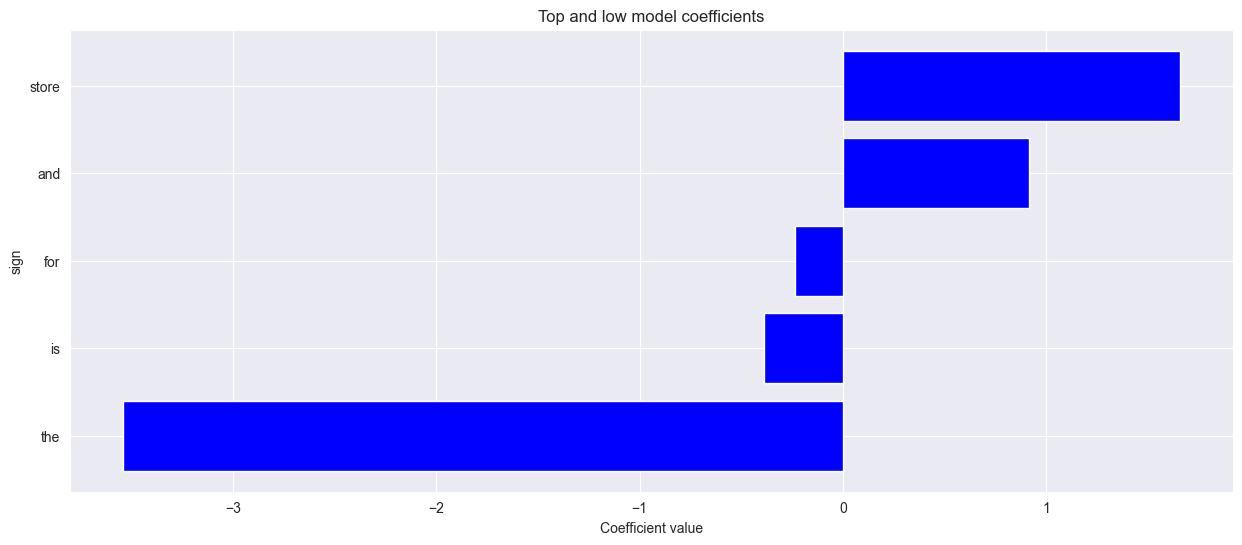

In [60]:
plt.figure(figsize=(15, 6))
plt.barh(range(len(top_coefficients)), coefficients.ravel()[top_coefficients], color='red')
plt.barh(range(len(bottom_coefficients)), coefficients.ravel()[bottom_coefficients], color='blue')
plt.yticks(range(len(top_coefficients)), feature_names[top_coefficients])
plt.xlabel("Coefficient value")
plt.ylabel("sign")
plt.title("Top and low model coefficients")
plt.show()

In [61]:
coefficients = grid.best_estimator_.named_steps["logisticregression"].coef_
print("Dimensions of model coefficients: {}".format(coefficients.shape))
print("Coefficients: {}".format(coefficients.ravel()[:]))

Dimensions of model coefficients: (1, 5)
Coefficients: [ 0.91644926 -0.23624172 -0.39068596  1.6568388  -3.54118748]


In [62]:
pipe = make_pipeline(TfidfVectorizer(), LogisticRegression()) 

param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_)) 
print("Best parameters: \n{}".format(grid.best_params_))

Best cross-validation score: 0.43
Best parameters: 
{'logisticregression__C': 0.001, 'tfidfvectorizer__ngram_range': (1, 3)}


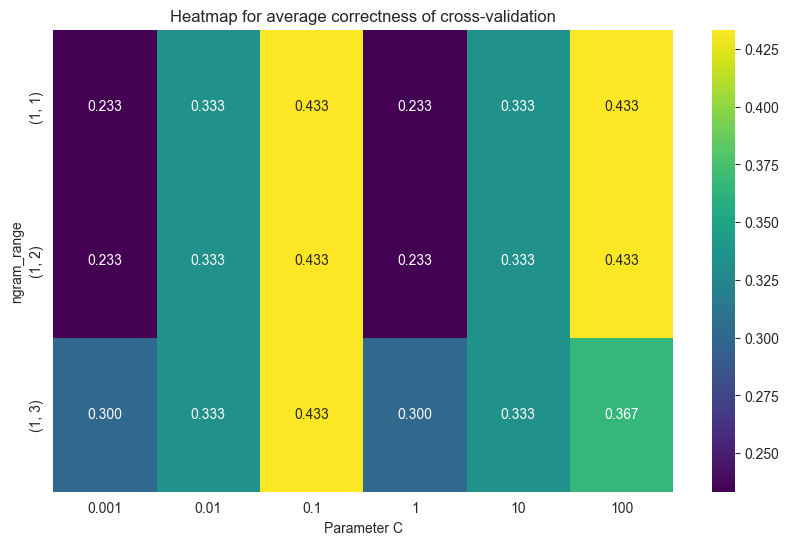

In [63]:
import seaborn as sns

grid_mean_scores = np.array(grid.cv_results_['mean_test_score']).reshape(3, 6)

plt.figure(figsize=(10, 6))
sns.heatmap(grid_mean_scores, annot=True, fmt=".3f", xticklabels=param_grid['logisticregression__C'],
            yticklabels=[str(i) for i in param_grid['tfidfvectorizer__ngram_range']], cmap="viridis")
plt.xlabel('Parameter C')
plt.ylabel('ngram_range')
plt.title('Heatmap for average correctness of cross-validation')
plt.show()